# Imports
**Other**
* CPU monitoring in terminal:  
```bash
top
```
* GPU monitoring in terminal:  
```bash
pip install gpustat
watch -c gpustat -cp --color
```

In [1]:
import sys
from math import ceil
import pandas as pd
# to save results to data directory
module_path = '..'
if module_path not in sys.path:
    sys.path.insert(1, module_path)
# increase displayed columns in jupyter notebook
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)

In [2]:
import os
import multiprocessing
import logging
import json
import numpy as np
import matplotlib.pyplot as plt
from src.outlier_model import OutlierModel


# increase displayed columns in jupyter notebook
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)

# temporarily remove deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

logging.basicConfig(format='%(asctime)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
logger = logging.getLogger("TimeSeries")
logger.setLevel(logging.INFO)

# Dataset

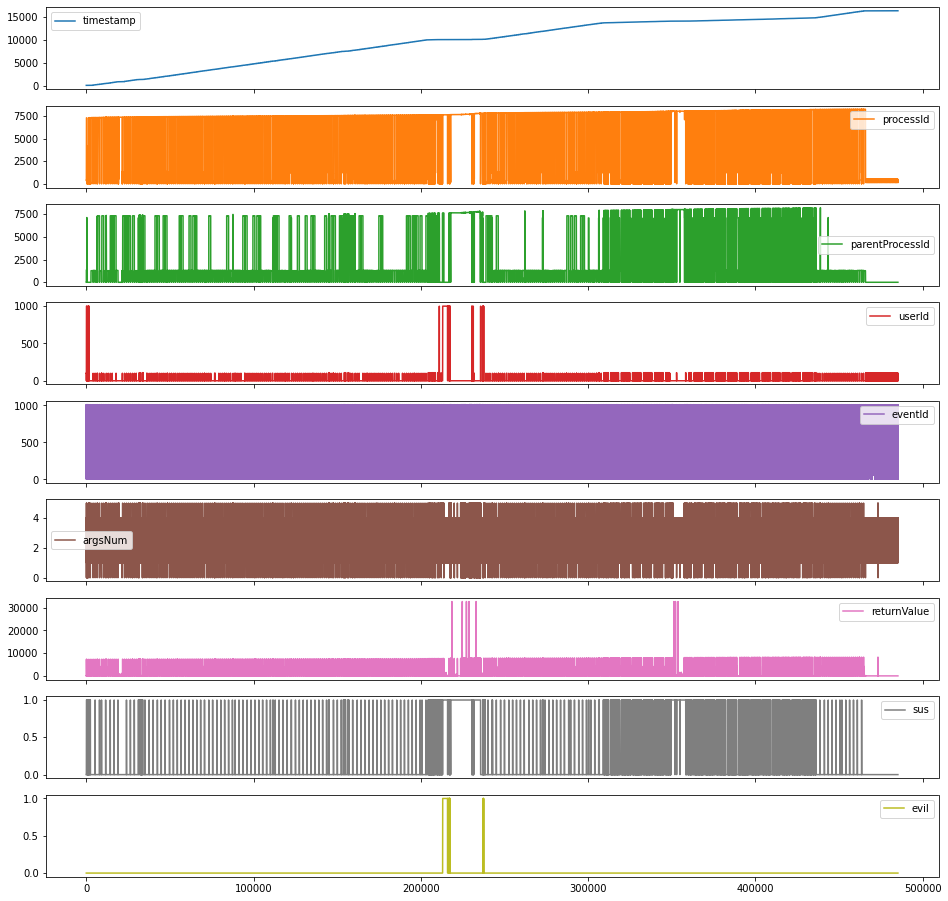

In [3]:
base_path = '#datasets'
df = pd.read_csv(f'{base_path}/BETH/labelled_2021may-ip-10-100-1-4.csv',index_col=False)

df.plot(subplots=True, figsize=(16, 16)); plt.legend(loc='best')

## Preprocessing
The [original paper](http://www.gatsby.ucl.ac.uk/~balaji/udl2021/accepted-papers/UDL2021-paper-033.pdf) outlines the preprocessing steps performed here

* timestamp - nothing
* processId - binary value of weather processID is 0,1,2
* threadId - nothing
* parentProcessId - same as processId
* userId - binary if userId < 1000 or userId >= 1000
* mountNamespace - weather or not mountNamespace = 4026531840 (mnt/ directory)
* processName - encode this (in the future) drop for now
* hostName - nothing (at the moment) drop for now
* eventId - as is
* eventName - drop it
* argsNum - as is
* returnValue - tri-value  -1 when negative, 0 when zero, 1 when positive
* stackAddresses - dropped
* args - dropped

In [4]:
# data_raw = df.copy()
# Drop unused columns
# data_raw.drop(['processName','hostName','eventName','stackAddresses','args'],axis=1,inplace=True)
#
# # Pre-process remaining columns
# data_raw['processId'] = df['processId'].apply(lambda x: (0 <= x <= 2).real)
# data_raw['parentProcessId'] = df['parentProcessId'].apply(lambda x: (0 <= x <= 2).real)
# data_raw['userId'] = df['userId'].apply(lambda x: (x < 1000).real)
# data_raw['mountNamespace'] = df['mountNamespace'].apply(lambda x: (x == 4026531840).real)
# data_raw['returnValue'] = df['returnValue'].apply(lambda x: np.sign(x) )
df.head()

,timestamp,processId,parentProcessId,userId,processName,hostName,eventId,eventName,argsNum,returnValue,args,sus,evil
0,131.874057,382,1,101,systemd-resolve,ip-10-100-1-4,1005,security_file_open,4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
1,131.874597,382,1,101,systemd-resolve,ip-10-100-1-4,257,openat,4,15,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
2,131.874796,382,1,101,systemd-resolve,ip-10-100-1-4,5,fstat,2,0,"[{'name': 'fd', 'type': 'int', 'value': 15}, {...",0,0
3,131.874743,382,1,101,systemd-resolve,ip-10-100-1-4,5,fstat,2,0,"[{'name': 'fd', 'type': 'int', 'value': 15}, {...",0,0
4,131.874975,382,1,101,systemd-resolve,ip-10-100-1-4,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 15}]",0,0


In [5]:
start_index = 0
end_index = 300000
data_test = df[start_index:end_index]

outlier_key = "userId"
m = 1000
preload_size = 10000
# plt.plot(data[40750:41250][outlier_key])
outlier_model = OutlierModel(m=m,std_dev_mult=5,
                             time_series=data_test[:preload_size][outlier_key].astype(np.float64),
                             egress=True)

In [6]:
fault = False
for index, row in data_test[preload_size:].iterrows():
    outlier_model.train_one(row[outlier_key])
    fault = outlier_model.predict_one(index)
    if index % 10000 == 0:
        print(f"Current Global index: {index}")

Current Global index: 10000


02/08/2022 09:20:36 PM:  Anomaly at Global index: 11000
02/08/2022 09:20:36 PM: max_mp: 13172.8523, metric:11533.8264: metric-max_mp: 1639.0259000000005 range: 4241.051600000001


Current Global index: 20000
Current Global index: 30000
Current Global index: 40000
Current Global index: 50000
Current Global index: 60000
Current Global index: 70000
Current Global index: 80000
Current Global index: 90000
Current Global index: 100000
Current Global index: 110000
Current Global index: 120000
Current Global index: 130000
Current Global index: 140000
Current Global index: 150000
Current Global index: 160000
Current Global index: 170000
Current Global index: 180000
Current Global index: 190000
Current Global index: 200000
Current Global index: 210000


02/08/2022 09:21:58 PM:  Anomaly at Global index: 213096
02/08/2022 09:21:58 PM: max_mp: 3659.2251, metric:1702.1034999999997: metric-max_mp: 1957.1216000000004 range: 2651.8156


Current Global index: 220000
Current Global index: 230000


02/08/2022 09:22:08 PM:  Anomaly at Global index: 237222
02/08/2022 09:22:08 PM: max_mp: 6013.0614, metric:3971.1048: metric-max_mp: 2041.9565999999995 range: 4198.655999999999


Current Global index: 240000
Current Global index: 250000
Current Global index: 260000
Current Global index: 270000
Current Global index: 280000
Current Global index: 290000


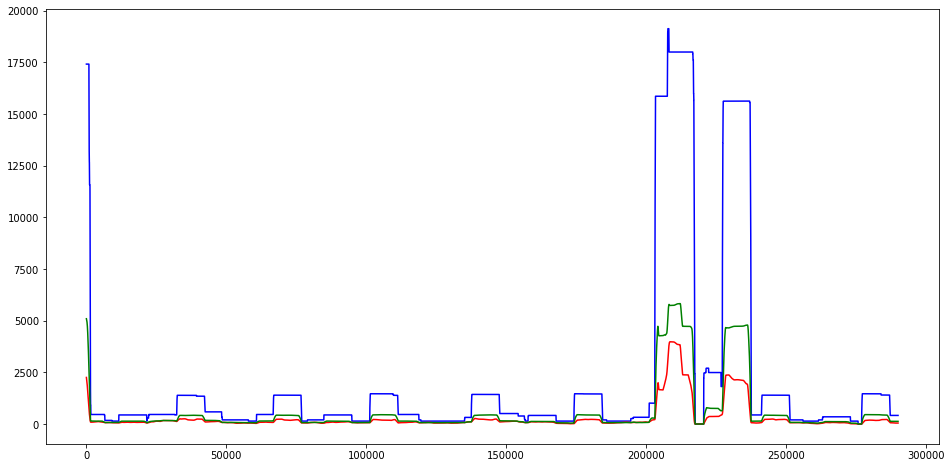

In [7]:
plt.figure(figsize=(16,8))

plt.plot(outlier_model.max_val,'b-',
         outlier_model.max_mean,'r-',
         outlier_model.max_std_dev,'g-')

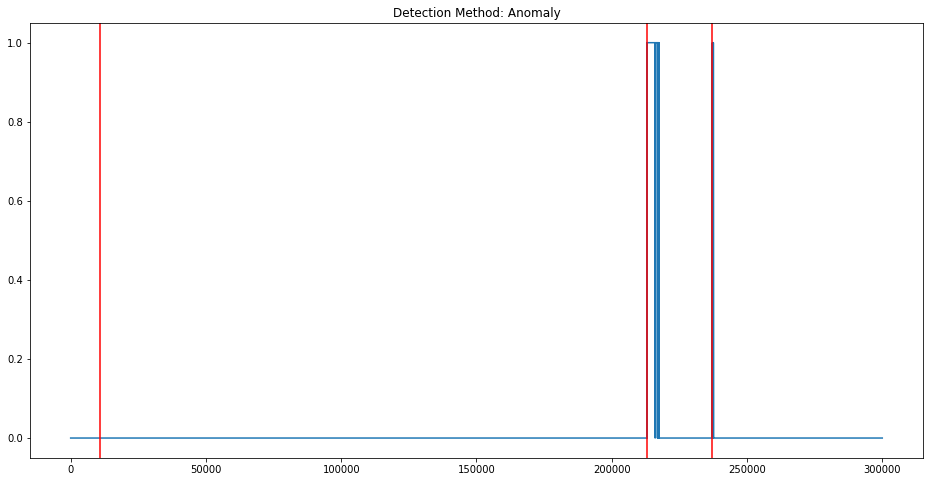

In [8]:
plt.figure(figsize=(16,8))
plt.plot(data_test["evil"])
plt.title(f"Detection Method: Anomaly")
for i in outlier_model.anomalies:
    plt.axvline(x=i,color='r')